(retrievalalgorithm)= 
# Sea Ice Thickness Retrieval Algorithm
## Introduction
The retrieval uses the fitted parameters from individual fits of ice thickness
to brightness temperatures and a minimization scheme including uncertainties
using the error covariance matrix of $T_{b,h}$ and $T_{b_v}$ at 1.4 GHz. In
contrast to the original {cite}`Huntemann2014` retrieval, the upper limit is not
capped but left open, but very loosely constrained by a background ice
thickness. In the following the original fit parameters from {cite}`Huntemann2014`
in the latest version are used for comparison and evaluation. However, the
original parameters where obtained for an incidence angle range from 40° to 50°
while the new fit parameters were obtained to match the CIMR incidence angle of
53°. The equations used for their fits are {eq}`eq:intensity` and
{eq}`eq:poldiff`. Equation {eq}`eq:intensity` is also used for fitting horizontal and
vertical polarization directly to the ice thickness dependence. The inversion of
this system in the $H$ and $V$ space is used to obtain the ice thickness.
Both, $T_{b,h}$ and $T_{b_v}$ were fitted to the ice thickness dependence in the {ref}`fw-model`.


In [1]:
using Pkg
Pkg.activate("../sit_atbd_env_jl")
#using Plots
using LaTeXStrings
using Optim
using ForwardDiff
import YAML
using Markdown
using Printf
using StaticArrays

  Activating project at `~/SeaIceThickness_ATBD/sit_atbd_env_jl`


In [2]:
#python stuff
using PythonCall
mpl=pyimport("matplotlib")
#mpl.use("Agg")
mpl.use("svg")
#mpl.use("module://juliacall.matplotlib") #some workaround for inline plotting
plt=pyimport("matplotlib.pyplot")

Python module: <module 'matplotlib.pyplot' from '/home/huntemann/SeaIceThickness_ATBD/sit_atbd_env_jl/.CondaPkg/env/lib/python3.11/site-packages/matplotlib/pyplot.py'>

In [3]:
I(p)=f(x)=p[2]-(p[2]-p[1])*exp(-x/p[3])
Q(p)=f(x)=p[2]-(p[2]-p[1])*exp(-(x/p[3])^p[4])


#reading fit parameters from file

fI(x)=I(pI)(x)
fQ(x)=Q(pQ)(x)

params=YAML.load_file("fit_params.yml")
const tbh_params,tbv_params,pI,pQ=getindex.(Ref(params),["ph","pv","pI","pQ"])


ff(p)=return f(x)=p[2]-(p[2]-p[1])*exp(-x/p[3])
sit_h=ff(tbh_params)
sit_v=ff(tbv_params)

Fw_TB(x,p)=SA[ff(p[1])(x), ff(p[2])(x)]
Fw_IQ(x)=[fI(x[1]), fQ(x[1])]

Fw_TB(x)=Fw_TB(x[1],(tbh_params,tbv_params))

Fw_TB (generic function with 2 methods)

## Retrieval definition
The retrieval is following a typical scheme with the objective to minimize

$$
χ^2(\mathbf y,\mathbf x,\mathbf S_e,\mathbf S_a,\mathbf x_a)=\left(\mathbf y-F(\mathbf x)\right)^\mathbf{T}\mathbf S_e^{-1}(\mathbf y-F(\mathbf x))+(\mathbf x_a-\mathbf x)^{\mathbf T}\mathbf S_a^{-1}(\mathbf x_a - \mathbf x) 
$$ (eq:chi2)

where $\mathbf y= \begin{bmatrix}T_{b,h}\\T_{b,v}\end{bmatrix}$ is the vector of input (measured) brightness temperatures at L-band, $\mathbf x$ is the result vector (in case of the retrieval of only one quantity, ice thickness, this is a scalar),  $\mathbf S_e$ is the error covariance matrix of the input brightness temperatures, $\mathbf S_a$ is the covariance matrix of the background values (in this case a scalar), $\textbf x_a$ is the background value (ice thickness) and $F$ is the forward operator, in our caes the individual fit function for a given ice thickness, i.e., 
$F(\mathbf x) = \begin{bmatrix}f_h(\mathbf x)\\ f_v(\mathbf x)\end{bmatrix}$, with $f_p(x)$ from {eq}`eq:intensity` and the corresponding parameters coming from Table {numref}`retrieval parameters`.

The optimal solution $\hat {\mathbf y}$ which minimizes equation {eq}`eq:chi2` is found by iteration. 
The uncertainty of $\mathbf y$ can then be obtained as 

$$
\mathbf {\hat S}_a= (\mathbf S_a^{-1}+\mathbf{ \hat M}^\mathbf T \mathbf S_e^{-1}\mathbf {\hat M})^{-1}, 
$$ (eq:error)

with $\mathbf {\hat M}$ is the Jacobian of the optimal solution of {eq}`eq:chi2` which is in this case also a scalar.

Some variables are fixed in this scheme, this is the background ice thickness
$\mathbf x_a=x_a=100$ cm and its variance $\mathbf S_a=S_a=20000\ cm^2$, which
is used here as a practical way to very loosely constrain the upper ice thickness range. Other
parameters are obtained from the CIMR satellite like $\mathbf y=
\begin{bmatrix}T_{b,h}\\T_{b,v}\end{bmatrix}$, the brightness temperatures at
L-band, and the diagonal components of the error covariance matrix $\mathbf
S_a$, for the off-diagonal of $\mathbf S_a$ there is no good estimate, but it
is not expected that the uncertainties of $T_{b,h}$ and $T_{b,v}$ are
uncorrelated. At least most physical effects which are not considered in this
empirical forward model, would have to go into the uncertainty of $T_{b,h}$ and
$T_{b,v}$ which introduce correlation. For the lack of a better estimate, we
claim a correlation of 0.6 which results in off-diagonal elements of
$0.6*\sigma_{Tbh}\sigma_{TBv}$. For illustration of the algorithm we use 

$$
\mathbf S_e = \begin{bmatrix}25 & 15\\ 15 & 25\end{bmatrix}
$$ (eq:tberror)

For the minimization of {eq}`eq:chi2` we use the Levenberg-Marquardt algorithm as described by {cite}`Rodgers2000` and {cite}`Marquardt1963`. An implementation in the Julia programming language {cite}`Bezanson2017julia` can be found below.


In [4]:
function retrieval(Ta,Se,Sa,xa,F)
    # easy retrieval method
    # Ta is a vector of length of input for one single retrieval length N
    # Se is the error covariance matrix of the input, i.e. length N x N
    # Sa is the error covariance matrix of the output, i.e. length M x M (the error of the background value)
    # xa is a background value where Sa is the error of, i.e. a vector of length M
    # F is a forward model receiving a input vector of length N and return an output of length M
    # ymin and ymax are the limits of the oupt regime where ot search in, both are of length M
    # returns Y, the output vector
    
    #defining error function to menimize as χ² 
    iSa=inv(Sa)
    iSe=inv(Se)
    χ²(y,x,iSe,iSa,xa,F)=(y.-F(x))'*(iSe*(y.-F(x)))+(xa.-x)'*(iSa*(xa.-x))
   if length(xa)==0
        xi=[maximize(x->-χ²(Ta,x,iSe,iSa,xa,F),0,10000).res.minimizer]
    else
        res=optimize(x->χ²(Ta,x,iSe,iSa,xa,F),xa)
        xi=res.minimizer
    end
#    @show χ²(Ta,y,Se,Sa,xa)
    M=ForwardDiff.jacobian(F,xi)
    xerr=inv(iSa+M'*iSe*M)
#    @show χ²(Ta,xi,iSe,iSa,xa,F)
    return xi[1],xerr[1]
end
    


retrieval(h,v)=retrieval([h,v],[25 15;15 25.0],fill(20000.,1,1),[100.],Fw_TB)


retrieval (generic function with 2 methods)

In [5]:
function lm_retrieval(Ta,Sₑ,Sₐ,xₐ,F)
    #Levenberg Marquardt method after Rodgers (2000)
    #target: find x so that F(x)=Ta, given
    #Ta: measurement vector
    #Sₑ: error covariance of measurement
    #Sₐ: error covariance of physical state 
    #xₐ: expected physical state (also used as start, i.e. first guess)
    #F: the forward model translating measument space into state space
    Sₐ⁻¹=inv(Sₐ)
    Sₑ⁻¹=inv(Sₑ)
    #function to minimize with changing input x
    J(y,x,Sₑ⁻¹,Sₐ⁻¹,xₐ,F)=(y.-F(x))'*(Sₑ⁻¹*(y.-F(x)))+(xₐ.-x)'*(Sₐ⁻¹*(xₐ.-x)) 
    xᵢ=copy(xₐ)
    Jᵢ=J(Ta,xᵢ,Sₑ⁻¹,Sₐ⁻¹,xₐ,F)
    γ=1e-5 #set to 0 for gauss newton
    for i=1:2000 
        Kᵢ=ForwardDiff.jacobian(F,xᵢ)
        Ŝ⁻¹=Sₐ⁻¹+Kᵢ'*Sₑ⁻¹*Kᵢ #eq 5.13
        xᵢ₊₁=xᵢ+((1+γ)*Sₐ⁻¹+Kᵢ'*Sₑ⁻¹*Kᵢ)\(Kᵢ'*Sₑ⁻¹*(Ta-F(xᵢ))-Sₐ⁻¹*(xᵢ-xₐ)) #eq 5.36
        Jᵢ₊₁=J(Ta,xᵢ₊₁,Sₑ⁻¹,Sₐ⁻¹,xₐ,F)
        d²=(xᵢ-xᵢ₊₁)'*Ŝ⁻¹*(xᵢ-xᵢ₊₁) #eq 5.29
        if Jᵢ₊₁<Jᵢ 
            γ/=2
        else
            γ*=10
            continue
        end
        xᵢ=xᵢ₊₁
        if d²<1e-10
            break
        end
        Jᵢ=Jᵢ₊₁
    end
    Kᵢ=ForwardDiff.jacobian(F,xᵢ)
    Ŝ=inv(Sₐ⁻¹+Kᵢ'*Sₑ⁻¹*Kᵢ) # eq 5.38
    
    return xᵢ,Ŝ
end


retrievallm(h,v)=first.(lm_retrieval(SA[h,v],SA[25 15;15 25.0],SMatrix{1,1,Float64,1}(20000.0),SA[100.],Fw_TB))

retrievallm (generic function with 1 method)

The comparison will be done with a least squares fit based $I$-$Q$-retrieval from Huntemann et al. 2014, i.e., the cost function is 

$$
c(x)=(I(x)-I_m)^2+(Q(x)-Q_m)^2
$$ (eq:IQcost)

which is minimized to obtain the best ice thickness $x$ for a given measured $I_m$ and $Q_m$.

In [7]:
cost(II,QQ)=f(x)=(fI(x)-II)^2+(fQ(x)-QQ)^2
retrieval_hun(ii,qq)=maximize(x->-cost(ii,qq)(x),0,200).res.minimizer 

retrieval_hun (generic function with 1 method)

(uncertainties)= 
## Uncertainties
The uncertainty follows {cite}`Patilea2019` using three terms:
* Uncertainty from the training data ice thickness increase within one day
* Native uncertainty from the of uncertainty of brightness temperatures
* Uncertainty from the ice concentration (not full ice coverage)

Technically, these uncertainties should be considered forward model errors and treated as such.

### Daily ice thickness variation
{numref}`fig:sitchange` shows the SIT uncertainty from daily ice thickness variations from {eq}`eq:CFDD_SIT` for three different reference temperatures. For the following we use $-25\ \text{°C}$ as uncertainty reference for contribution to the combined error calculation.
Rearranging {eq}`eq:CFDD_SIT`, for a fixed temperature, the cumulative freezing degree days to reach a certain ice thickness is 

$$t_{\text{S}}(\text{d}_{\text{ice}},T)=-(\text{d}_{\text{ice}}/1.33)^{(1/0.58)}/(T+1.8)
$$

$$ \sigma_{\text{growth}} = 0.68\ (d_{\text{ice}}(t_\text{S}+1\ \text {day})-d_{\text{ice}}(t_\text{S}))
$$ (eq:SIC_uncertainty)



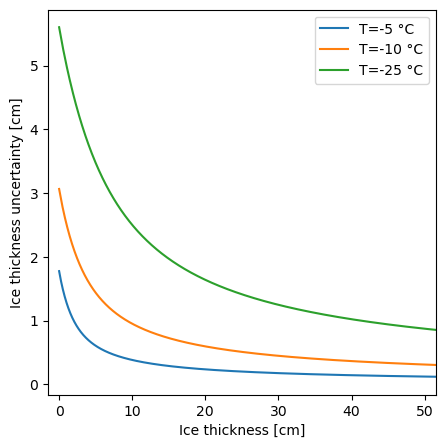

In [8]:
cfdd(temp,duration)=1.33*(-(temp+1.8)*duration)^0.58

days=0:0.01:200

max_ig(T,t)=cfdd(T,t+1)-cfdd(T,t-0)
sittime(sit,temp)=(1/(sit*1.33*(-temp+1.8)))^(1/0.58)
fig=plt.figure(figsize=[5,5])
ax=fig.add_subplot(111)

for temp in [-5,-10,-25]    
    ax.plot(cfdd.(temp,days),max_ig.((temp,),days)*0.68,label="T=$temp °C")
end
ax.legend()
ax.set_xlim(-1.5,51.5)
ax.set_xlabel("Ice thickness [cm]")
ax.set_ylabel("Ice thickness uncertainty [cm]")

#plt.show();
display(fig)

### Propagation of brightness temperature uncertainty
The uncertainty of the CIMR brightness temperatures propagate into uncertainty in the retrieval natively. These are described by equation {eq}`eq:error` and they are a direct result of the sensitivity of the forward modeled brightness temperatures to changes in physical parameters.

### Uncertainty from full ice cover assumption
The assumption of full sea ice coverage within the CIMR L-band footprint originates from the unknown ice concentration. It can occur that a part of the footprint is open water, which lowers the brightness temperature and thus make the ice look thinner. This error is accounted for with a $5\ \%$ error on ice concentration. The $p_1$ for each parameter in {numref}`retrieval parameters` gives the open water tie point, i.e. at 0 cm ice thickness. For estimating the uncertainty, these values are mixed with the weight of the ice concentration as

$$ T_{b,h/v}(\text{SIC})=T_{b,h/v}\text{SIC} + p_{1,h/v}(1-\text{SIC})$$ 

so that 

$$ σ_\text{SIC} = \frac{F^{-1}\left(T_{b,h/v}(0.95)\right)+F^{-1}\left(T_{b,h/v}(1.05)\right)}{2}
$$ (eq:sicerror)




In [9]:

function owerr(x) #original open water error
    owtbh=65
    owtbv=155
    owi=owtbv/2+owtbh/2
    owq=owtbv-owtbh
    owf=-0.05
    I=fI(x)*(1-owf)+owi*owf
    Q=fQ(x)*(1-owf)+owq*owf
    sit_minus=retrieval_hun(I,Q)
    owf=0.05
    I=fI(x)*(1-owf)+owi*owf
    Q=fQ(x)*(1-owf)+owq*owf
    sit_plus=retrieval_hun(I,Q)
    return ((x-sit_plus)^2+(x-sit_minus)^2)^0.5
end
#ff2_p= [100.2,234.1,12.7]
#qparams = [51.0, 19.4, 31.8, 1.65]  # HBparams


function owerr_2(x,tbs=nothing) #new openwater error
    if tbs==nothing
        tbh,tbv=Fw_TB(x)
    else
        tbh,tbv=tbs
    end
    owtbh=67.7
    owtbv=148.9
    owf=-0.05
    ntbh=(tbh*(1-owf)+(owtbh*owf))
    ntbv=(tbv*(1-owf)+(owtbv*owf))
    owf=0.05
    sit_minus=retrieval(ntbh,ntbv)[1]
    ntbh=(tbh*(1-owf)+(owtbh*owf))
    ntbv=(tbv*(1-owf)+(owtbv*owf))
    sit_plus=retrieval(ntbh,ntbv)[1]
    return ((x-sit_plus)^2+(x-sit_minus)^2)^0.5
end


function retrerr(x,ra)
    IR=fI(x)
    QR=fQ(x)
    ixmax=retrieval_hun(IR+ra*sqrt(2)/2,QR)
    ixmin=retrieval_hun(IR-ra*sqrt(2)/2,QR)
    qxmax=retrieval_hun(IR,QR+ra*sqrt(2))
    qxmin=retrieval_hun(IR,QR-ra*sqrt(2))
    (maximum(x.-[ixmax,ixmin])^2+maximum(x.-[qxmax,qxmin])^2)^0.5
end

sittime(sit,temp)=-(max(0,sit)/1.33)^(1/0.58)/(temp+1.8)

function cfdd_unc(sit)
    t=sittime(sit,-25)
    return (cfdd(-25,t+1)-cfdd(-25,t))*0.68
end

function comb_error(sit)
    return sqrt(cfdd_unc(sit)^2+retrerr(sit,5)^2+owerr(sit)^2)
end

function comb_error_2(sit)
    return sqrt(cfdd_unc(sit)^2+retrieval(Fw_TB(sit)...)[2]+owerr_2(sit)^2)
end

function comb_error_2(sit,tbh,tbv)
    return sqrt(cfdd_unc(sit)^2+retrieval(tbh,tbv)[2]+owerr_2(sit,(tbh,tbv))^2)
end

comb_error_2 (generic function with 2 methods)

### Total uncertainty
The overall uncertainty is calculated as a composition of individual uncertainties in the parameter space, i.e. on ice thickness directly as

$$ 
σ_\text{tot}=\sqrt{\left(σ_{\text{SIC}}^2+σ_\text{growth}^2 + \sigma_\text{retr}^2\right)},
$$ (eq:totaluncertainty)
assuming they are uncorrelated. The indiviual terms as well as the total uncertainty are shown in {numref}`fig:siterrors` on the left. At small ice thicknesses, the largest contribution is from the ice growth error up to about $15\ \text{cm}$. From there, the sensitivity to changes in ice thickness gets smaller and the uncertainty from the SIC takes over the higher contribution. The retrieval error as the propagated brightness temperature uncertainty, shows the highest values only at higher ice thicknesses. On the right of {numref}`fig:siterrors` the relative error is shown. The best accuracy is reached at ice thicknesses between $10\ \text{cm}$ and $60$ cm with the relative error below $40\ \%$.

```{note}
The ice concentration error is not a fixed function of the ice thickness as it is evaluated in the brightness temperature space and thus depends on the input brightness temperatures. 
```

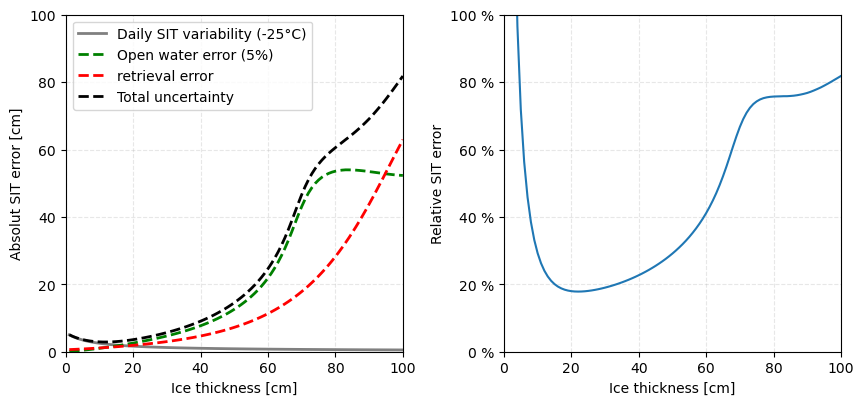

In [10]:
sit=1:100

fig2=plt.figure(figsize=[10,5])#,constrained_layout=true);
ax1=fig2.add_subplot(121);

ax1.plot(sit,cfdd_unc.(sit),label="Daily SIT variability (-25°C)",lw=2,c="gray");

ax1.plot(sit,owerr_2.(sit),label="Open water error (5%)",lw=2,ls="--",c="green");
ax1.plot(sit,[retrieval(Fw_TB(s)...)[2]^0.5 for s in sit],label="retrieval error",lw=2,ls="--",c="red");
ax1.plot(sit,comb_error_2.(sit),label="Total uncertainty",lw=2,ls="--",c="black");
ax1.set_aspect("equal", adjustable="box")

ax1.legend()
ax1.set_xlim(0,sit.stop)
ax1.set_ylim(0,sit.stop)
ax1.set_xlabel("Ice thickness [cm]")
ax1.set_ylabel("Absolut SIT error [cm]")
ax1.grid(linestyle="--",alpha=0.3)

ax2=fig2.add_subplot(122)
ax2.plot(sit,comb_error_2.(sit)./sit.*100);
ax2.set_ylim(0,100)
ax2.set_xlim(0,100)

ticks=0:20:100
ax2.set_yticks(ticks,labels=[(@sprintf "%i %%" i) for i in ticks])
ax2.set_ylabel("Relative SIT error")
ax2.set_xlabel("Ice thickness [cm]")
ax2.set_aspect("equal", adjustable="box")
ax2.grid(linestyle="--",alpha=0.3)

fig2.subplots_adjust(wspace=0.3);

display(fig2)

In [13]:
Qs=20:90
Is=100:270
out=[retrievallm(ii-qq/2,ii+qq/2)[1] for ii=Is,qq=Qs]
out_err=[retrievallm(ii-qq/2,ii+qq/2)[2] for ii=Is,qq=Qs]
out_orig=[retrieval_hun(ii,qq) for ii=Is,qq=Qs];

The overall retrieval {term}`SIT` for a given combination of $T_{b,h}$ and $T_{b,v}$ is shown in a contour plot in {numref}`fig:retrievalcomp`. The dots represent the forward model evaluation for a given ice thickness in $10\ \text{cm}$ steps, converted to $I-Q$-space. The orange dots are the CIMR algorithm described in this ATBD, the red dots correspond to the $I-Q$ space fit variant from {cite}`Huntemann2014` and {cite}`Patilea2019`. The bottom right dots show $0\ \text{cm}$ ice thickness, where both function essentially give the same point. At the $10\ \text{cm}$ up to $40\ \text{cm}$ there is a slight discrepancy in the direction of polarization difference. Also, at higher SIT values the red points do not reach as high intensities and polarization difference as the orange points of the new retrieval.

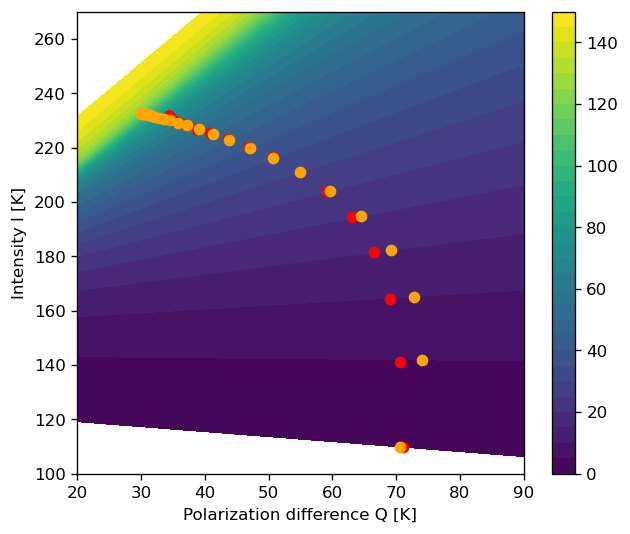

In [29]:

fig3=plt.figure(figsize=[6,5],dpi=120)
ax=fig3.add_subplot(111)
sit=0:5:150

im=ax.contourf(Qs,Is,out.-0.0,levels=sit)

h,v=sit_h.(sit),sit_v.(sit)
allq,alli=v.-h,h./2 .+v./2

ax.plot(fQ.(sit),fI.(sit),lw=0,marker="o",color="red",label="I-Q LstSQ")
ax.plot(allq,alli,lw=0,marker="o",color="orange",label="H-V LstSQ")

ax.set_xlabel("Polarization difference Q [K]")
ax.set_ylabel("Intensity I [K]")

fig3.colorbar(im)

#plt.show(format="png")
display(MIME("image/png"),fig3)